In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import random
from time import time

from scipy.special import comb, loggamma, lambertw
from scipy.stats import multinomial, expon

import lifelines

from silence_tensorflow import silence_tensorflow
silence_tensorflow()
import tensorflow as tf

config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config = config)

import os, shutil
import json
import subprocess

import mps
import pwexp
from net_model import *
from mps_models import *

# Load data - Fashion-MNIST

In [2]:
fashion_mnist = tf.keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

In [3]:
i_valid_train = pd.Series(train_labels).isin([0,1,2,3,4]).to_numpy()
i_valid_test = pd.Series(test_labels).isin([0,1,2,3,4]).to_numpy()

# Filtra apenas as imagens com labels 0, 1, 2, 3 e 4
train_images = train_images[i_valid_train]
train_labels = train_labels[i_valid_train]
test_images = test_images[i_valid_test]
test_labels = test_labels[i_valid_test]

# Normaliza as imagens para o intervalo (0,1)
train_images = train_images / np.max(train_images)
test_images = test_images / np.max(test_images)

x_train = tf.constant(train_images, dtype = tf.float64)
x_test = tf.constant(test_images, dtype = tf.float64)

print("Dimensão do conjunto de treino: {}".format(train_images.shape))
print("Dimensão do conjunto de teste: {}".format(test_images.shape))

Dimensão do conjunto de treino: (30000, 28, 28)
Dimensão do conjunto de teste: (5000, 28, 28)


In [4]:
np.unique(train_labels)

array([0, 1, 2, 3, 4], dtype=uint8)

# Parameters recovery

Nesta seção inicial, façamos o estudo do quão bem o modelo consegue recuperar os parâmetros reais estabelecidos em um caso controlado. Para isso, consideramos três diferentes tamanhos amostrais de treino e teste. Para cada um desses três conjuntos gerados, aplicaremos uma simulação do modelo para cada distribuição e avaliaremos se o resultado assintótico na estimação do vetor de parâmetros $\boldsymbol \alpha$ é satisfatória, assim como verificaremos as estatísticas de bondade do ajuste como o erro quadrático médio da função de sobrevivência, da função basal de risco, da taxa de cura, dos fatores médios de risco em escala log e do valor absoluto para o número de fatores de risco de cada indivíduo.

Temos o interesse em estabelecer uma proporção de $70\%$ das observações no conjunto de treinamento, $15\%$ no conjunto de validação e $15\%$ no conjunto de teste. Fixamos os tamanhos amostrais para o conjunto de treinamento em $n = 500, 1000, 5000$ em cada cenário, obtendo a seguinte tabela aproximada de tamanhos amostrais:

<table>
    <tr>
        <td> Cenário </td> <td> $n_{\text{train}}$ </td> <td> $n_{\text{total}}$ </td> <td> $n_{\text{val}}$ </td> <td> $n_{\text{test}}$ </td>
    </tr>
    <tr>
        <td> 1 </td> <td> 500 </td> <td> 716 </td> <td> 108 </td> <td> 108 </td>
    </tr>
    <tr>
        <td> 2 </td> <td> 1000 </td> <td> 1428 </td> <td> 214 </td> <td> 214 </td>
    </tr>
    <tr>
        <td> 3 </td> <td> 5000 </td> <td> 7142 </td> <td> 1071 </td> <td> 1071 </td>
    </tr>
</table>

Abaixo, traçamos todo o processo para a geração de uma única amostra, considerando o caso em que o conjunto de treinamento tem tamanho $n_\text{train} = 500$. Ao final deste notebook, utilizamos todas as ideias desenvolvidas ao longo do processo para criar uma função geral que amostra as imagens e gera uma amostra do modelo requisitado.

Devido a complicações teóricas de alguns modelos não suportarem probabilidades de cura baixas, faremos dois Cenários de simulação. No primeiro, consideremos apenas os modelos flexíveis para todas as probabilidades de cura possíveis no intervalo $(0,1)$. No Cenário 1, consideramos as probabilidades de cura dos grupos como 0.08, 0.14, 0.22, 0.45, 0.9. As distribuições utilizadas neste caso serão:

* Poisson
* Logarítmica
* Geométrica (=NB(q=1))
* NB(q=2)
* Bernoulli (=Bin(q=1))
* Bin(q=5)

Curiosamente, todas essas distribuições pertencem à classe particular das Distribuições de Séries de Potências, que representam um caso particular das distribuições MPS.

Para o Cenário 2, consideramos as probabilidades 0.55, 0.65, 0.75, 0.85, 0.95 para as primeiras cinco classes do dataset Fashion-MNIST. Neste caso, consideraremos apenas as distribuições

* Borel (=RGP(q=1))
* RGP(q=2)
* Haight (=Geeta(q=2))
* Geeta(q=3)

Dessas distribuições, os intervalos em que as probabilidades de cura se encontram quando associados ao modelo MPScr são, respectivamente, $(e^{-1}, 1)$, $()$

## Scenario 1

In [5]:
probs1 = np.array([0.9, 0.45, 0.22, 0.14, 0.08])
cure_probs1 = pd.DataFrame({"Classe": ["0", "1", "2", "3", "4"], "p_0": [0.9, 0.45, 0.22, 0.14, 0.08]})
cure_probs_dict1 = {0: 0.9, 1:0.45, 2:0.22, 3:0.14, 4: 0.08}
cure_probs_dict1 = np.vectorize(cure_probs_dict1.get)
cure_probs1

,Classe,p_0
0,0,0.90
1,1,0.45
2,2,0.22
3,3,0.14
4,4,0.08


In [6]:
i_train = np.arange(train_images.shape[0])
i_test = np.arange(test_images.shape[0])

### First sample size ($n = 716$)

In [7]:
def get_theta(log_a, log_phi, C, C_inv, sup, p_0, theta_min = None, theta_max = None):
    '''
        Dadas as especificações para a distribuição das causas latentes e um vetor de probabilidades de cura,
        inverte a função e retorna o vetor de parâmetros theta dos indivíduos
    '''
    theta = C_inv( np.exp(log_a(0.0) - np.log(p_0)) )
    
    # Se theta é limitado inferiormente por um valor theta_min > 0, valores de theta obtidos abaixo do limite são levados para o limite inferior do parâmetro
    if(theta_min is not None):
        theta[theta <= theta_min] = theta_min + 1.0e-5
    # Se theta é limitado superiormente por um valor theta_max > 0, valores de theta obtidos acima do limite são levados para o limite superior do parâmetro
    if(theta_min is not None):
        theta[theta >= theta_max] = theta_max - 1.0e-5
        
    return theta

Veja que alguns modelos não suportam probabilidades de cura inferiores a determinados valores. Esses modelos são Borel, RGP(q), Haight e Geeta(q), respectivamente. Sendo assim, para a primeira rodada de simulações em que controlamos as probabilidades de 0.08, 0.14, 0.22, 0.45 (inviáveis para alguns modelos, como a Haight) e 0.9, deixemos essas três distribuições de fora. A segunda leva de simulações irá concentrar apenas em classes de indivíduos com alta probabilidade de cura, de preferência maior que o maior dos limites (1/2 da Haight, neste caso), de modo que todos possam ser testados satisfatoriamente.

In [28]:
np.max(i_test1)

4854

In [30]:
np.max(i_train_val1)

29841

In [8]:
n_train1 = 500
n_val1 = 108
n_test1 = 108
n1 = n_train1 + n_val1 + n_test1

# ---------------------------- Sorteia os índices do conjunto de dados geral para cada cenário ----------------------------
i_train_val1 = np.random.choice(i_train, size = n_train1 + n_val1, replace = True)
i_test1 = np.random.choice(i_test, size = n_test1, replace = True)
x_train1 = tf.gather(x_train, i_train_val1[:n_train1])
x_val1 = tf.gather(x_train, i_train_val1[n_train1:])
x_test1 = tf.gather(x_test, i_test1)
label_train1 = train_labels[i_train_val1[:n_train1]]
label_val1 = train_labels[i_train_val1[n_train1:]]
label_test1 = test_labels[i_test1]
p_train1 = cure_probs_dict1(label_train1)
p_val1 = cure_probs_dict1(label_val1)
p_test1 = cure_probs_dict1(label_test1)

# ---------------------------- Poisson ----------------------------
theta_train_poisson1 = get_theta(log_a_poisson, log_phi_poisson, C_poisson, C_inv_poisson, sup_poisson, p_train1, theta_min = theta_min_poisson, theta_max = theta_max_poisson)
theta_val_poisson1 = get_theta(log_a_poisson, log_phi_poisson, C_poisson, C_inv_poisson, sup_poisson, p_val1, theta_min = theta_min_poisson, theta_max = theta_max_poisson)
theta_test_poisson1 = get_theta(log_a_poisson, log_phi_poisson, C_poisson, C_inv_poisson, sup_poisson, p_test1, theta_min = theta_min_poisson, theta_max = theta_max_poisson)

# ---------------------------- Logarítmica ----------------------------
theta_train_log1 = get_theta(log_a_log, log_phi_log, C_log, C_inv_log, sup_log, p_train1, theta_min = theta_min_log, theta_max = theta_max_log)
theta_val_log1 = get_theta(log_a_log, log_phi_log, C_log, C_inv_log, sup_log, p_val1, theta_min = theta_min_log, theta_max = theta_max_log)
theta_test_log1 = get_theta(log_a_log, log_phi_log, C_log, C_inv_log, sup_log, p_test1, theta_min = theta_min_log, theta_max = theta_max_log)

# ---------------------------- Geométrica ----------------------------
theta_train_geo1 = get_theta(log_a_nb(1), log_phi_nb(1), C_nb(1), C_inv_nb(1), sup_nb, p_train1, theta_min = theta_min_nb, theta_max = theta_max_nb)
theta_val_geo1 = get_theta(log_a_nb(1), log_phi_nb(1), C_nb(1), C_inv_nb(1), sup_nb, p_val1, theta_min = theta_min_nb, theta_max = theta_max_nb)
theta_test_geo1 = get_theta(log_a_nb(1), log_phi_nb(1), C_nb(1), C_inv_nb(1), sup_nb, p_test1, theta_min = theta_min_nb, theta_max = theta_max_nb)

# ---------------------------- Binomial Negativa (q = 2) ----------------------------
theta_train_2nb1 = get_theta(log_a_nb(2), log_phi_nb(2), C_nb(2), C_inv_nb(2), sup_nb, p_train1, theta_min = theta_min_nb, theta_max = theta_max_nb)
theta_val_2nb1 = get_theta(log_a_nb(2), log_phi_nb(2), C_nb(2), C_inv_nb(2), sup_nb, p_val1, theta_min = theta_min_nb, theta_max = theta_max_nb)
theta_test_2nb1 = get_theta(log_a_nb(2), log_phi_nb(2), C_nb(2), C_inv_nb(2), sup_nb, p_test1, theta_min = theta_min_nb, theta_max = theta_max_nb)

# ---------------------------- Bernoulli ----------------------------
theta_train_bern1 = get_theta(log_a_bin(1), log_phi_bin(1), C_bin(1), C_inv_bin(1), sup_bin(1), p_train1, theta_min = theta_min_bin, theta_max = theta_max_bin)
theta_val_bern1 = get_theta(log_a_bin(1), log_phi_bin(1), C_bin(1), C_inv_bin(1), sup_bin(1), p_val1, theta_min = theta_min_bin, theta_max = theta_max_bin)
theta_test_bern1 = get_theta(log_a_bin(1), log_phi_bin(1), C_bin(1), C_inv_bin(1), sup_bin(1), p_test1, theta_min = theta_min_bin, theta_max = theta_max_bin)

# ---------------------------- Binomial (q = 5) ----------------------------
theta_train_5bin1 = get_theta(log_a_bin(5), log_phi_bin(5), C_bin(5), C_inv_bin(5), sup_bin(5), p_train1, theta_min = theta_min_bin, theta_max = theta_max_bin)
theta_val_5bin1 = get_theta(log_a_bin(5), log_phi_bin(5), C_bin(5), C_inv_bin(5), sup_bin(5), p_val1, theta_min = theta_min_bin, theta_max = theta_max_bin)
theta_test_5bin1 = get_theta(log_a_bin(5), log_phi_bin(5), C_bin(5), C_inv_bin(5), sup_bin(5), p_test1, theta_min = theta_min_bin, theta_max = theta_max_bin)

Façamos o risco base ser dado por uma distribuição $\text{Exp}(1)$, de modo que, independente do número de nós escolhidos para o modelo piecewise-exponential, obtenhamos em média, valores $\alpha_k$ próximos de um.

In [9]:
def generate_data(log_a, log_phi, theta, sup, low_c, high_c):
    '''
        Dada a especificação do modelo e um vetor com os parâmetros individuais, gera os tempos de vida e censuras de cada indivíduo.
        low_c e high_c definem o intervalo para a geração dos tempos de censura, seguindo uma distribuição U[low_c, high_c]
    '''
    n = len(theta)
    m = mps.rvs(log_a, log_phi, theta, sup, size = 10)
    
    cured = np.zeros(n)
    delta = cured.copy()
    t = cured.copy()
    
    # Censorship times
    c = np.random.uniform(low = low_c, high = high_c, size = n)
    
    for i in range(n):
        if(m[i] == 0):
            t[i] = c[i]
            cured[i] = 1
        else:
            # Risco base segue uma distribuição Exp(1)
            z = expon.rvs(loc = 0.0, scale = 1.0, size = int(m[i]))
            t[i] = np.min(z)
    
    # Atualiza as posições não censuradas para delta = 1
    delta[t < c] = 1
    # Os tempos censurados passam a assumir o valor do tempo de censura
    t[t >= c] = c[t >= c]
    
    # Retorna os tempos, deltas e o vetor de causas latentes (que na prática é desconhecido)
    return m, t, delta, cured

**Poisson**

In [10]:
low_c = 0
high_c = 6

m_train_poisson1, t_train_poisson1, delta_train_poisson1, cured_train_poisson1 = \
generate_data(log_a_poisson, log_phi_poisson, theta_train_poisson1, sup_poisson, low_c, high_c)
print("Proporção de censuras treino Poisson: {:.4f}".format(np.mean(delta_train_poisson1)))
print("Proporção de curados treino Poisson: {:.4f}".format(np.mean(cured_train_poisson1)))

m_val_poisson1, t_val_poisson1, delta_val_poisson1, cured_val_poisson1 = \
generate_data(log_a_poisson, log_phi_poisson, theta_val_poisson1, sup_poisson, low_c, high_c)
print("Proporção de censuras validação Poisson: {:.4f}".format(np.mean(delta_val_poisson1)))
print("Proporção de curados validação Poisson: {:.4f}".format(np.mean(cured_val_poisson1)))

m_test_poisson1, t_test_poisson1, delta_test_poisson1, cured_test_poisson1 = \
generate_data(log_a_poisson, log_phi_poisson, theta_test_poisson1, sup_poisson, low_c, high_c)
print("Proporção de censuras validação Poisson: {:.4f}".format(np.mean(delta_test_poisson1)))
print("Proporção de curados validação Poisson: {:.4f}".format(np.mean(cured_test_poisson1)))

Proporção de censuras treino Poisson: 0.5640
Proporção de curados treino Poisson: 0.3720
Proporção de censuras validação Poisson: 0.5833
Proporção de curados validação Poisson: 0.3519
Proporção de censuras validação Poisson: 0.6389
Proporção de curados validação Poisson: 0.2963


**Logarithmic**

In [11]:
dlow_c = 0
high_c = 6

m_train_log1, t_train_log1, delta_train_log1, cured_train_log1 = \
generate_data(log_a_log, log_phi_log, theta_train_log1, sup_log, low_c, high_c)
print("Proporção de censuras treino Logarítmica: {:.4f}".format(np.mean(delta_train_log1)))
print("Proporção de curados treino Logarítmica: {:.4f}".format(np.mean(cured_train_log1)))

m_val_log1, t_val_log1, delta_val_log1, cured_val_log1 = \
generate_data(log_a_log, log_phi_log, theta_val_log1, sup_log, low_c, high_c)
print("Proporção de censuras validação Logarítmica: {:.4f}".format(np.mean(delta_val_log1)))
print("Proporção de curados validação Logarítmica: {:.4f}".format(np.mean(cured_val_log1)))

m_test_log1, t_test_log1, delta_test_log1, cured_test_log1 = \
generate_data(log_a_log, log_phi_log, theta_test_log1, sup_log, low_c, high_c)
print("Proporção de censuras validação Logarítmica: {:.4f}".format(np.mean(delta_test_log1)))
print("Proporção de curados validação Logarítmica: {:.4f}".format(np.mean(cured_test_log1)))


Proporção de censuras treino Logarítmica: 0.6200
Proporção de curados treino Logarítmica: 0.3460
Proporção de censuras validação Logarítmica: 0.6204
Proporção de curados validação Logarítmica: 0.3611
Proporção de censuras validação Logarítmica: 0.6204
Proporção de curados validação Logarítmica: 0.3611


**Geometric = NB(q = 1)**

In [12]:
dlow_c = 0
high_c = 6

m_train_geo1, t_train_geo1, delta_train_geo1, cured_train_geo1 = \
generate_data(log_a_nb(1), log_phi_nb(1), theta_train_geo1, sup_nb, low_c, high_c)
print("Proporção de censuras treino Geométrica: {:.4f}".format(np.mean(delta_train_geo1)))
print("Proporção de curados treino Geométrica: {:.4f}".format(np.mean(cured_train_geo1)))

m_val_geo1, t_val_geo1, delta_val_geo1, cured_val_geo1 = \
generate_data(log_a_nb(1), log_phi_nb(1), theta_val_geo1, sup_nb, low_c, high_c)
print("Proporção de censuras validação Geométrica: {:.4f}".format(np.mean(delta_val_geo1)))
print("Proporção de curados validação Geométrica: {:.4f}".format(np.mean(cured_val_geo1)))

m_test_geo1, t_test_geo1, delta_test_geo1, cured_test_geo1 = \
generate_data(log_a_nb(1), log_phi_nb(1), theta_test_geo1, sup_nb, low_c, high_c)
print("Proporção de censuras validação Geométrica: {:.4f}".format(np.mean(delta_test_geo1)))
print("Proporção de curados validação Geométrica: {:.4f}".format(np.mean(cured_test_geo1)))

Proporção de censuras treino Geométrica: 0.6080
Proporção de curados treino Geométrica: 0.3380
Proporção de censuras validação Geométrica: 0.6111
Proporção de curados validação Geométrica: 0.3426
Proporção de censuras validação Geométrica: 0.6111
Proporção de curados validação Geométrica: 0.3611


**Negative Binomial (q = 2)**

In [13]:
dlow_c = 0
high_c = 6

m_train_2nb1, t_train_2nb1, delta_train_2nb1, cured_train_2nb1 = \
generate_data(log_a_nb(1), log_phi_nb(1), theta_train_2nb1, sup_nb, low_c, high_c)
print("Proporção de censuras treino NB(2): {:.4f}".format(np.mean(delta_train_2nb1)))
print("Proporção de curados treino NB(2): {:.4f}".format(np.mean(cured_train_2nb1)))

m_val_2nb1, t_val_2nb1, delta_val_2nb1, cured_val_2nb1 = \
generate_data(log_a_nb(2), log_phi_nb(2), theta_val_2nb1, sup_nb, low_c, high_c)
print("Proporção de censuras validação NB(2): {:.4f}".format(np.mean(delta_val_2nb1)))
print("Proporção de curados validação NB(2): {:.4f}".format(np.mean(cured_val_2nb1)))

m_test_2nb1, t_test_2nb1, delta_test_2nb1, cured_test_2nb1 = \
generate_data(log_a_nb(2), log_phi_nb(2), theta_test_2nb1, sup_nb, low_c, high_c)
print("Proporção de censuras validação NB(2): {:.4f}".format(np.mean(delta_test_2nb1)))
print("Proporção de curados validação NB(2): {:.4f}".format(np.mean(cured_test_2nb1)))

Proporção de censuras treino NB(2): 0.4180
Proporção de curados treino NB(2): 0.5420
Proporção de censuras validação NB(2): 0.5833
Proporção de curados validação NB(2): 0.3981
Proporção de censuras validação NB(2): 0.6019
Proporção de curados validação NB(2): 0.3796


**Bernoulli**

In [14]:
dlow_c = 0
high_c = 6

m_train_bern1, t_train_bern1, delta_train_bern1, cured_train_bern1 = \
generate_data(log_a_bin(1), log_phi_bin(1), theta_train_bern1, sup_bin(1), low_c, high_c)
print("Proporção de censuras treino Bernoulli: {:.4f}".format(np.mean(delta_train_bern1)))
print("Proporção de curados treino Bernoulli: {:.4f}".format(np.mean(cured_train_bern1)))

m_val_bern1, t_val_bern1, delta_val_bern1, cured_val_bern1 = \
generate_data(log_a_bin(1), log_phi_bin(1), theta_val_bern1, sup_bin(1), low_c, high_c)
print("Proporção de censuras validação Bernoulli: {:.4f}".format(np.mean(delta_val_bern1)))
print("Proporção de curados validação Bernoulli: {:.4f}".format(np.mean(cured_val_bern1)))

m_test_bern1, t_test_bern1, delta_test_bern1, cured_test_bern1 = \
generate_data(log_a_bin(1), log_phi_bin(1), theta_test_bern1, sup_bin(1), low_c, high_c)
print("Proporção de censuras validação Bernoulli: {:.4f}".format(np.mean(delta_test_bern1)))
print("Proporção de curados validação Bernoulli: {:.4f}".format(np.mean(cured_test_bern1)))

Proporção de censuras treino Bernoulli: 0.5360
Proporção de curados treino Bernoulli: 0.3700
Proporção de censuras validação Bernoulli: 0.4444
Proporção de curados validação Bernoulli: 0.4352
Proporção de censuras validação Bernoulli: 0.5370
Proporção de curados validação Bernoulli: 0.3148


**Binomial (q = 5)**

In [15]:
dlow_c = 0
high_c = 6

m_train_5bin1, t_train_5bin1, delta_train_5bin1, cured_train_5bin1 = \
generate_data(log_a_bin(5), log_phi_bin(5), theta_train_5bin1, sup_bin(5), low_c, high_c)
print("Proporção de censuras treino Bin(5): {:.4f}".format(np.mean(delta_train_5bin1)))
print("Proporção de curados treino Bin(5): {:.4f}".format(np.mean(cured_train_5bin1)))

m_val_5bin1, t_val_5bin1, delta_val_5bin1, cured_val_5bin1 = \
generate_data(log_a_bin(5), log_phi_bin(5), theta_val_5bin1, sup_bin(5), low_c, high_c)
print("Proporção de censuras validação Bin(5): {:.4f}".format(np.mean(delta_val_5bin1)))
print("Proporção de curados validação Bin(5): {:.4f}".format(np.mean(cured_val_5bin1)))

m_test_5bin1, t_test_5bin1, delta_test_5bin1, cured_test_5bin1 = \
generate_data(log_a_bin(5), log_phi_bin(5), theta_test_5bin1, sup_bin(5), low_c, high_c)
print("Proporção de censuras validação Bin(5): {:.4f}".format(np.mean(delta_test_5bin1)))
print("Proporção de curados validação Bin(5): {:.4f}".format(np.mean(cured_test_5bin1)))

Proporção de censuras treino Bin(5): 0.5740
Proporção de curados treino Bin(5): 0.3520
Proporção de censuras validação Bin(5): 0.6296
Proporção de curados validação Bin(5): 0.3148
Proporção de censuras validação Bin(5): 0.6111
Proporção de curados validação Bin(5): 0.3148


In [16]:
def plot_lifelines(t, delta, cured, ax, title = ""):
    KMfitter = lifelines.KaplanMeierFitter()
    KMfitter.fit(t, delta)
    KMfitter.plot_survival_function(show_censors = False, color = "black", ax = ax)
    ax.axhline( np.mean(cured), color = "red", linestyle = "dashed")
    ax.set_ylim(0,1)
    ax.set_title(title, fontsize = 20)

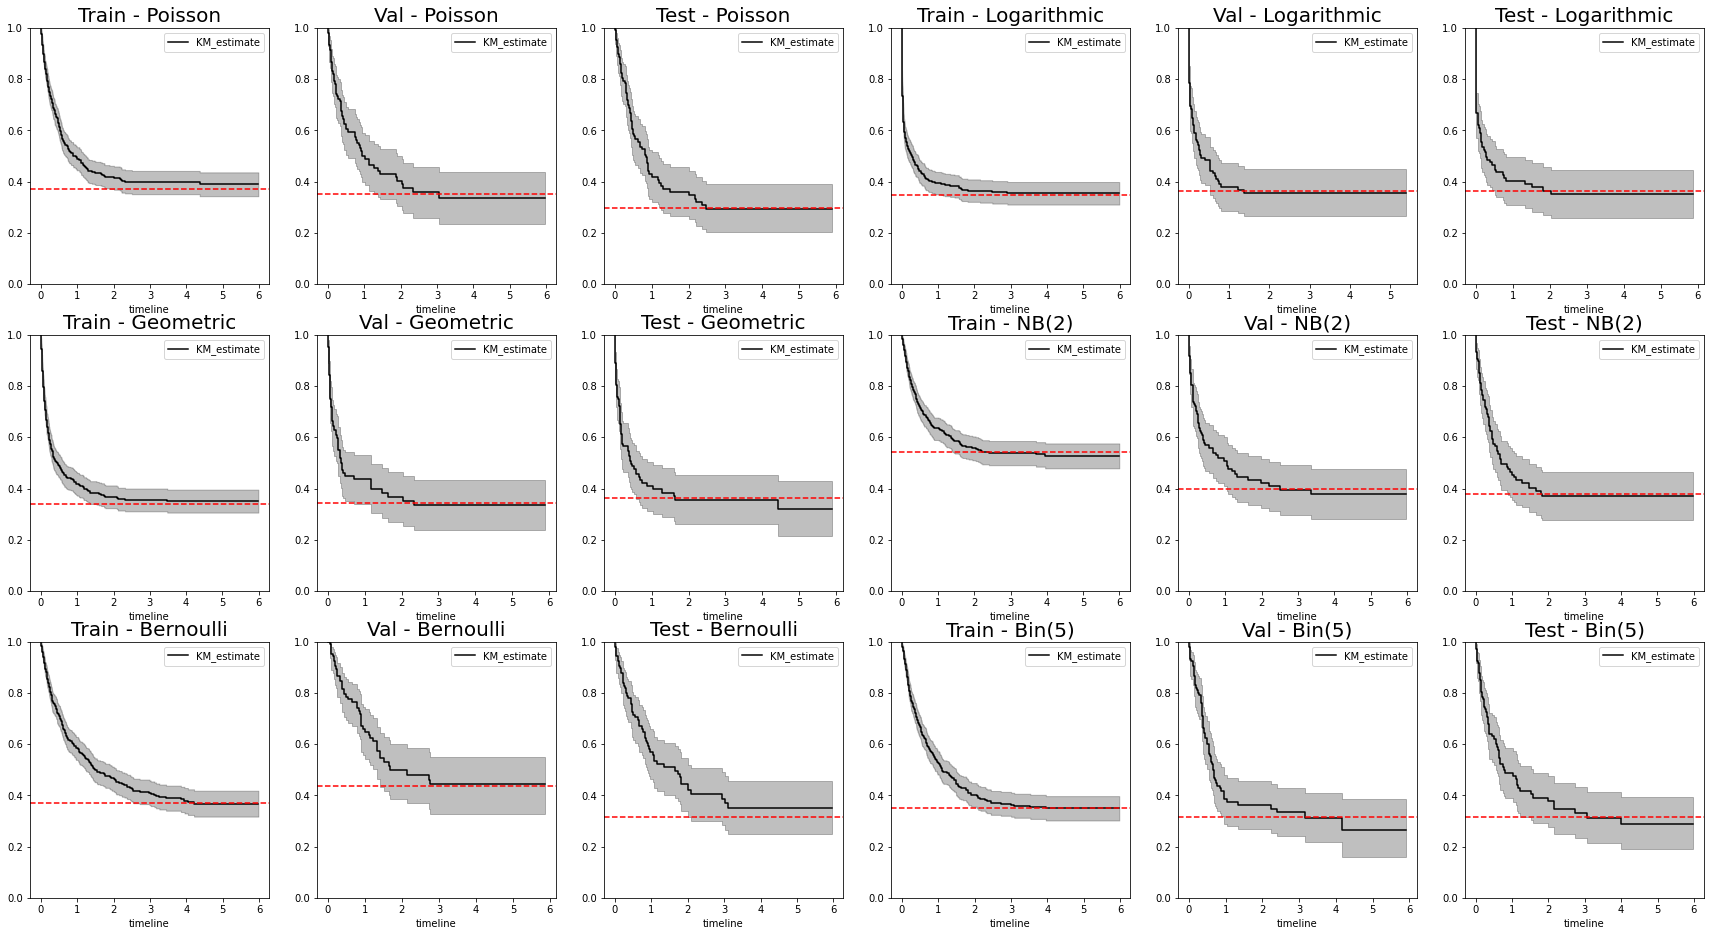

In [17]:
fig, ax = plt.subplots(nrows = 3, ncols = 6, figsize = (30,16))

# ---------------------------- Poisson ----------------------------
plot_lifelines(t_train_poisson1, delta_train_poisson1, cured_train_poisson1, ax[0,0], "Train - Poisson")
plot_lifelines(t_val_poisson1, delta_val_poisson1, cured_val_poisson1, ax[0,1], "Val - Poisson")
plot_lifelines(t_test_poisson1, delta_test_poisson1, cured_test_poisson1, ax[0,2], "Test - Poisson")

# ---------------------------- Logarítmica ----------------------------
plot_lifelines(t_train_log1, delta_train_log1, cured_train_log1, ax[0,3], "Train - Logarithmic")
plot_lifelines(t_val_log1, delta_val_log1, cured_val_log1, ax[0,4], "Val - Logarithmic")
plot_lifelines(t_test_log1, delta_test_log1, cured_test_log1, ax[0,5], "Test - Logarithmic")

# ---------------------------- Geométrica ----------------------------
plot_lifelines(t_train_geo1, delta_train_geo1, cured_train_geo1, ax[1,0], "Train - Geometric")
plot_lifelines(t_val_geo1, delta_val_geo1, cured_val_geo1, ax[1,1], "Val - Geometric")
plot_lifelines(t_test_geo1, delta_test_geo1, cured_test_geo1, ax[1,2], "Test - Geometric")

# ---------------------------- Binomial Negativa (q = 2) ----------------------------
plot_lifelines(t_train_2nb1, delta_train_2nb1, cured_train_2nb1, ax[1,3], "Train - NB(2)")
plot_lifelines(t_val_2nb1, delta_val_2nb1, cured_val_2nb1, ax[1,4], "Val - NB(2)")
plot_lifelines(t_test_2nb1, delta_test_2nb1, cured_test_2nb1, ax[1,5], "Test - NB(2)")

# ---------------------------- Bernoulli ----------------------------
plot_lifelines(t_train_bern1, delta_train_bern1, cured_train_bern1, ax[2,0], "Train - Bernoulli")
plot_lifelines(t_val_bern1, delta_val_bern1, cured_val_bern1, ax[2,1], "Val - Bernoulli")
plot_lifelines(t_test_bern1, delta_test_bern1, cured_test_bern1, ax[2,2], "Test - Bernoulli")

# ---------------------------- Binomial (q = 5) ----------------------------
plot_lifelines(t_train_5bin1, delta_train_5bin1, cured_train_5bin1, ax[2,3], "Train - Bin(5)")
plot_lifelines(t_val_5bin1, delta_val_5bin1, cured_val_5bin1, ax[2,4], "Val - Bin(5)")
plot_lifelines(t_test_5bin1, delta_test_5bin1, cured_test_5bin1, ax[2,5], "Test - Bin(5)")

plt.show()

## Scenario 2

In [18]:
probs2 = np.array([0.55, 0.65, 0.75, 0.85, 0.95])
cure_probs2 = pd.DataFrame({"Classe": ["0", "1", "2", "3", "4"], "p_0": [0.55, 0.65, 0.75, 0.85, 0.95]})
cure_probs_dict2 = {0: 0.55, 1:0.65, 2:0.75, 3:0.85, 4: 0.95}
cure_probs_dict2 = np.vectorize(cure_probs_dict2.get)
cure_probs2

,Classe,p_0
0,0,0.55
1,1,0.65
2,2,0.75
3,3,0.85
4,4,0.95


In [19]:
p_train2 = cure_probs_dict2(label_train1)
p_val2 = cure_probs_dict2(label_val1)
p_test2 = cure_probs_dict2(label_test1)

In [20]:
# ---------------------------- Borel ----------------------------
theta_train_borel2 = get_theta(log_a_borel, log_phi_borel, C_borel, C_inv_borel, sup_borel, p_train2, theta_min = theta_min_borel, theta_max = theta_max_borel)
theta_val_borel2 = get_theta(log_a_borel, log_phi_borel, C_borel, C_inv_borel, sup_borel, p_val2, theta_min = theta_min_borel, theta_max = theta_max_borel)
theta_test_borel2 = get_theta(log_a_borel, log_phi_borel, C_borel, C_inv_borel, sup_borel, p_test2, theta_min = theta_min_borel, theta_max = theta_max_borel)

# ---------------------------- RGP (q = 2) ----------------------------
theta_train_2rgp2 = get_theta(log_a_rgp(2), log_phi_rgp(2), C_rgp(2), C_inv_rgp(2), sup_rgp, p_train2, theta_min = theta_min_rgp, theta_max = theta_max_rgp(2))
theta_val_2rgp2 = get_theta(log_a_rgp(2), log_phi_rgp(2), C_rgp(2), C_inv_rgp(2), sup_rgp, p_val2, theta_min = theta_min_rgp, theta_max = theta_max_rgp(2))
theta_test_2rgp2 = get_theta(log_a_rgp(2), log_phi_rgp(2), C_rgp(2), C_inv_rgp(2), sup_rgp, p_test2, theta_min = theta_min_rgp, theta_max = theta_max_rgp(2))

# ---------------------------- RGP (q = -1/10) ----------------------------
theta_train_01rgp2 = get_theta(log_a_rgp(-1/10), log_phi_rgp(-1/10), C_rgp(-1/10), C_inv_rgp(-1/10), sup_rgp, p_train2, theta_min = theta_min_rgp, theta_max = theta_max_rgp(-1/10))
theta_val_01rgp2 = get_theta(log_a_rgp(-1/10), log_phi_rgp(-1/10), C_rgp(-1/10), C_inv_rgp(-1/10), sup_rgp, p_val2, theta_min = theta_min_rgp, theta_max = theta_max_rgp(-1/10))
theta_test_01rgp2 = get_theta(log_a_rgp(-1/10), log_phi_rgp(-1/10), C_rgp(-1/10), C_inv_rgp(-1/10), sup_rgp, p_test2, theta_min = theta_min_rgp, theta_max = theta_max_rgp(-1/10))

# ---------------------------- Haight ----------------------------
theta_train_haight2 = get_theta(log_a_haight, log_phi_haight, C_haight, C_inv_haight, sup_haight, p_train2, theta_min = theta_min_haight, theta_max = theta_max_haight)
theta_val_haight2 = get_theta(log_a_haight, log_phi_haight, C_haight, C_inv_haight, sup_haight, p_val2, theta_min = theta_min_haight, theta_max = theta_max_haight)
theta_test_haight2 = get_theta(log_a_haight, log_phi_haight, C_haight, C_inv_haight, sup_haight, p_test2, theta_min = theta_min_haight, theta_max = theta_max_haight)

# ---------------------------- Geeta (q = 3) ----------------------------
theta_train_3geeta2 = get_theta(log_a_geeta(3), log_phi_geeta(3), C_geeta(3), C_inv_geeta(3), sup_geeta, p_train2, theta_min = theta_min_geeta, theta_max = theta_max_geeta(3))
theta_val_3geeta2 = get_theta(log_a_geeta(3), log_phi_geeta(3), C_geeta(3), C_inv_geeta(3), sup_geeta, p_val2, theta_min = theta_min_geeta, theta_max = theta_max_geeta(3))
theta_test_3geeta2 = get_theta(log_a_geeta(3), log_phi_geeta(3), C_geeta(3), C_inv_geeta(3), sup_geeta, p_test2, theta_min = theta_min_geeta, theta_max = theta_max_geeta(3))

**Borel**

In [21]:
dlow_c = 0
high_c = 6

m_train_borel2, t_train_borel2, delta_train_borel2, cured_train_borel2 = \
generate_data(log_a_borel, log_phi_borel, theta_train_borel2, sup_borel, low_c, high_c)
print("Proporção de censuras treino Borel: {:.4f}".format(np.mean(delta_train_borel2)))
print("Proporção de curados treino Borel: {:.4f}".format(np.mean(cured_train_borel2)))

m_val_borel2, t_val_borel2, delta_val_borel2, cured_val_borel2 = \
generate_data(log_a_borel, log_phi_borel, theta_val_borel2, sup_borel, low_c, high_c)
print("Proporção de censuras validação Borel: {:.4f}".format(np.mean(delta_val_borel2)))
print("Proporção de curados validação Borel: {:.4f}".format(np.mean(cured_val_borel2)))

m_test_borel2, t_test_borel2, delta_test_borel2, cured_test_borel2 = \
generate_data(log_a_borel, log_phi_borel, theta_test_borel2, sup_borel, low_c, high_c)
print("Proporção de censuras validação Borel: {:.4f}".format(np.mean(delta_test_borel2)))
print("Proporção de curados validação Borel: {:.4f}".format(np.mean(cured_test_borel2)))

Proporção de censuras treino Borel: 0.1840
Proporção de curados treino Borel: 0.7820
Proporção de censuras validação Borel: 0.2685
Proporção de curados validação Borel: 0.7037
Proporção de censuras validação Borel: 0.2037
Proporção de curados validação Borel: 0.7870


**RGP(q = 2)**

In [22]:
dlow_c = 0
high_c = 6

m_train_2rgp2, t_train_2rgp2, delta_train_2rgp2, cured_train_2rgp2 = \
generate_data(log_a_rgp(2), log_phi_rgp(2), theta_train_2rgp2, sup_rgp(2), low_c, high_c)
print("Proporção de censuras treino 2rgp: {:.4f}".format(np.mean(delta_train_2rgp2)))
print("Proporção de curados treino 2rgp: {:.4f}".format(np.mean(cured_train_2rgp2)))

m_val_2rgp2, t_val_2rgp2, delta_val_2rgp2, cured_val_2rgp2 = \
generate_data(log_a_rgp(2), log_phi_rgp(2), theta_val_2rgp2, sup_rgp(2), low_c, high_c)
print("Proporção de censuras validação 2rgp: {:.4f}".format(np.mean(delta_val_2rgp2)))
print("Proporção de curados validação 2rgp: {:.4f}".format(np.mean(cured_val_2rgp2)))

m_test_2rgp2, t_test_2rgp2, delta_test_2rgp2, cured_test_2rgp2 = \
generate_data(log_a_rgp(2), log_phi_rgp(2), theta_test_2rgp2, sup_rgp(2), low_c, high_c)
print("Proporção de censuras validação 2rgp: {:.4f}".format(np.mean(delta_test_2rgp2)))
print("Proporção de curados validação 2rgp: {:.4f}".format(np.mean(cured_test_2rgp2)))

Proporção de censuras treino 2rgp: 0.2360
Proporção de curados treino 2rgp: 0.7460
Proporção de censuras validação 2rgp: 0.2315
Proporção de curados validação 2rgp: 0.7222
Proporção de censuras validação 2rgp: 0.1852
Proporção de curados validação 2rgp: 0.8056


**RGP(q = -1/10)**

In [23]:
dlow_c = 0
high_c = 6

m_train_01rgp2, t_train_01rgp2, delta_train_01rgp2, cured_train_01rgp2 = \
generate_data(log_a_rgp(-1/10), log_phi_rgp(-1/10), theta_train_01rgp2, sup_rgp(-1/10), low_c, high_c)
print("Proporção de censuras treino 2rgp: {:.4f}".format(np.mean(delta_train_2rgp2)))
print("Proporção de curados treino 2rgp: {:.4f}".format(np.mean(cured_train_2rgp2)))

m_val_01rgp2, t_val_01rgp2, delta_val_01rgp2, cured_val_01rgp2 = \
generate_data(log_a_rgp(-1/10), log_phi_rgp(-1/10), theta_val_01rgp2, sup_rgp(-1/10), low_c, high_c)
print("Proporção de censuras validação 2rgp: {:.4f}".format(np.mean(delta_val_2rgp2)))
print("Proporção de curados validação 2rgp: {:.4f}".format(np.mean(cured_val_2rgp2)))

m_test_01rgp2, t_test_01rgp2, delta_test_01rgp2, cured_test_01rgp2 = \
generate_data(log_a_rgp(-1/10), log_phi_rgp(-1/10), theta_test_01rgp2, sup_rgp(-1/10), low_c, high_c)
print("Proporção de censuras validação 2rgp: {:.4f}".format(np.mean(delta_test_2rgp2)))
print("Proporção de curados validação 2rgp: {:.4f}".format(np.mean(cured_test_2rgp2)))

Proporção de censuras treino 2rgp: 0.2360
Proporção de curados treino 2rgp: 0.7460
Proporção de censuras validação 2rgp: 0.2315
Proporção de curados validação 2rgp: 0.7222
Proporção de censuras validação 2rgp: 0.1852
Proporção de curados validação 2rgp: 0.8056


**Haight (Catalan)**

In [24]:
dlow_c = 0
high_c = 6

m_train_haight2, t_train_haight2, delta_train_haight2, cured_train_haight2 = \
generate_data(log_a_haight, log_phi_haight, theta_train_haight2, sup_haight, low_c, high_c)
print("Proporção de censuras treino Haight: {:.4f}".format(np.mean(delta_train_haight2)))
print("Proporção de curados treino Haight: {:.4f}".format(np.mean(cured_train_haight2)))

m_val_haight2, t_val_haight2, delta_val_haight2, cured_val_haight2 = \
generate_data(log_a_haight, log_phi_haight, theta_val_haight2, sup_haight, low_c, high_c)
print("Proporção de censuras validação Haight: {:.4f}".format(np.mean(delta_val_haight2)))
print("Proporção de curados validação Haight: {:.4f}".format(np.mean(cured_val_haight2)))

m_test_haight2, t_test_haight2, delta_test_haight2, cured_test_haight2 = \
generate_data(log_a_haight, log_phi_haight, theta_test_haight2, sup_haight, low_c, high_c)
print("Proporção de censuras validação Haight: {:.4f}".format(np.mean(delta_test_haight2)))
print("Proporção de curados validação Haight: {:.4f}".format(np.mean(cured_test_haight2)))

Proporção de censuras treino Haight: 0.2020
Proporção de curados treino Haight: 0.7840
Proporção de censuras validação Haight: 0.1852
Proporção de curados validação Haight: 0.7963
Proporção de censuras validação Haight: 0.1852
Proporção de curados validação Haight: 0.7963


**Geeta (q = 3)**

In [25]:
dlow_c = 0
high_c = 6

m_train_3geeta2, t_train_3geeta2, delta_train_3geeta2, cured_train_3geeta2 = \
generate_data(log_a_geeta(3), log_phi_geeta(3), theta_train_3geeta2, sup_geeta, low_c, high_c)
print("Proporção de censuras treino Geeta(3): {:.4f}".format(np.mean(delta_train_3geeta2)))
print("Proporção de curados treino Geeta(3): {:.4f}".format(np.mean(cured_train_3geeta2)))

m_val_3geeta2, t_val_3geeta2, delta_val_3geeta2, cured_val_3geeta2 = \
generate_data(log_a_geeta(3), log_phi_geeta(3), theta_val_3geeta2, sup_geeta, low_c, high_c)
print("Proporção de censuras validação Geeta(3): {:.4f}".format(np.mean(delta_val_3geeta2)))
print("Proporção de curados validação Geeta(3): {:.4f}".format(np.mean(cured_val_3geeta2)))

m_test_3geeta2, t_test_3geeta2, delta_test_3geeta2, cured_test_3geeta2 = \
generate_data(log_a_geeta(3), log_phi_geeta(3), theta_test_3geeta2, sup_geeta, low_c, high_c)
print("Proporção de censuras validação Geeta(3): {:.4f}".format(np.mean(delta_test_3geeta2)))
print("Proporção de curados validação Geeta(3): {:.4f}".format(np.mean(cured_test_3geeta2)))

Proporção de censuras treino Geeta(3): 0.2420
Proporção de curados treino Geeta(3): 0.7300
Proporção de censuras validação Geeta(3): 0.2315
Proporção de curados validação Geeta(3): 0.7222
Proporção de censuras validação Geeta(3): 0.1944
Proporção de curados validação Geeta(3): 0.7963


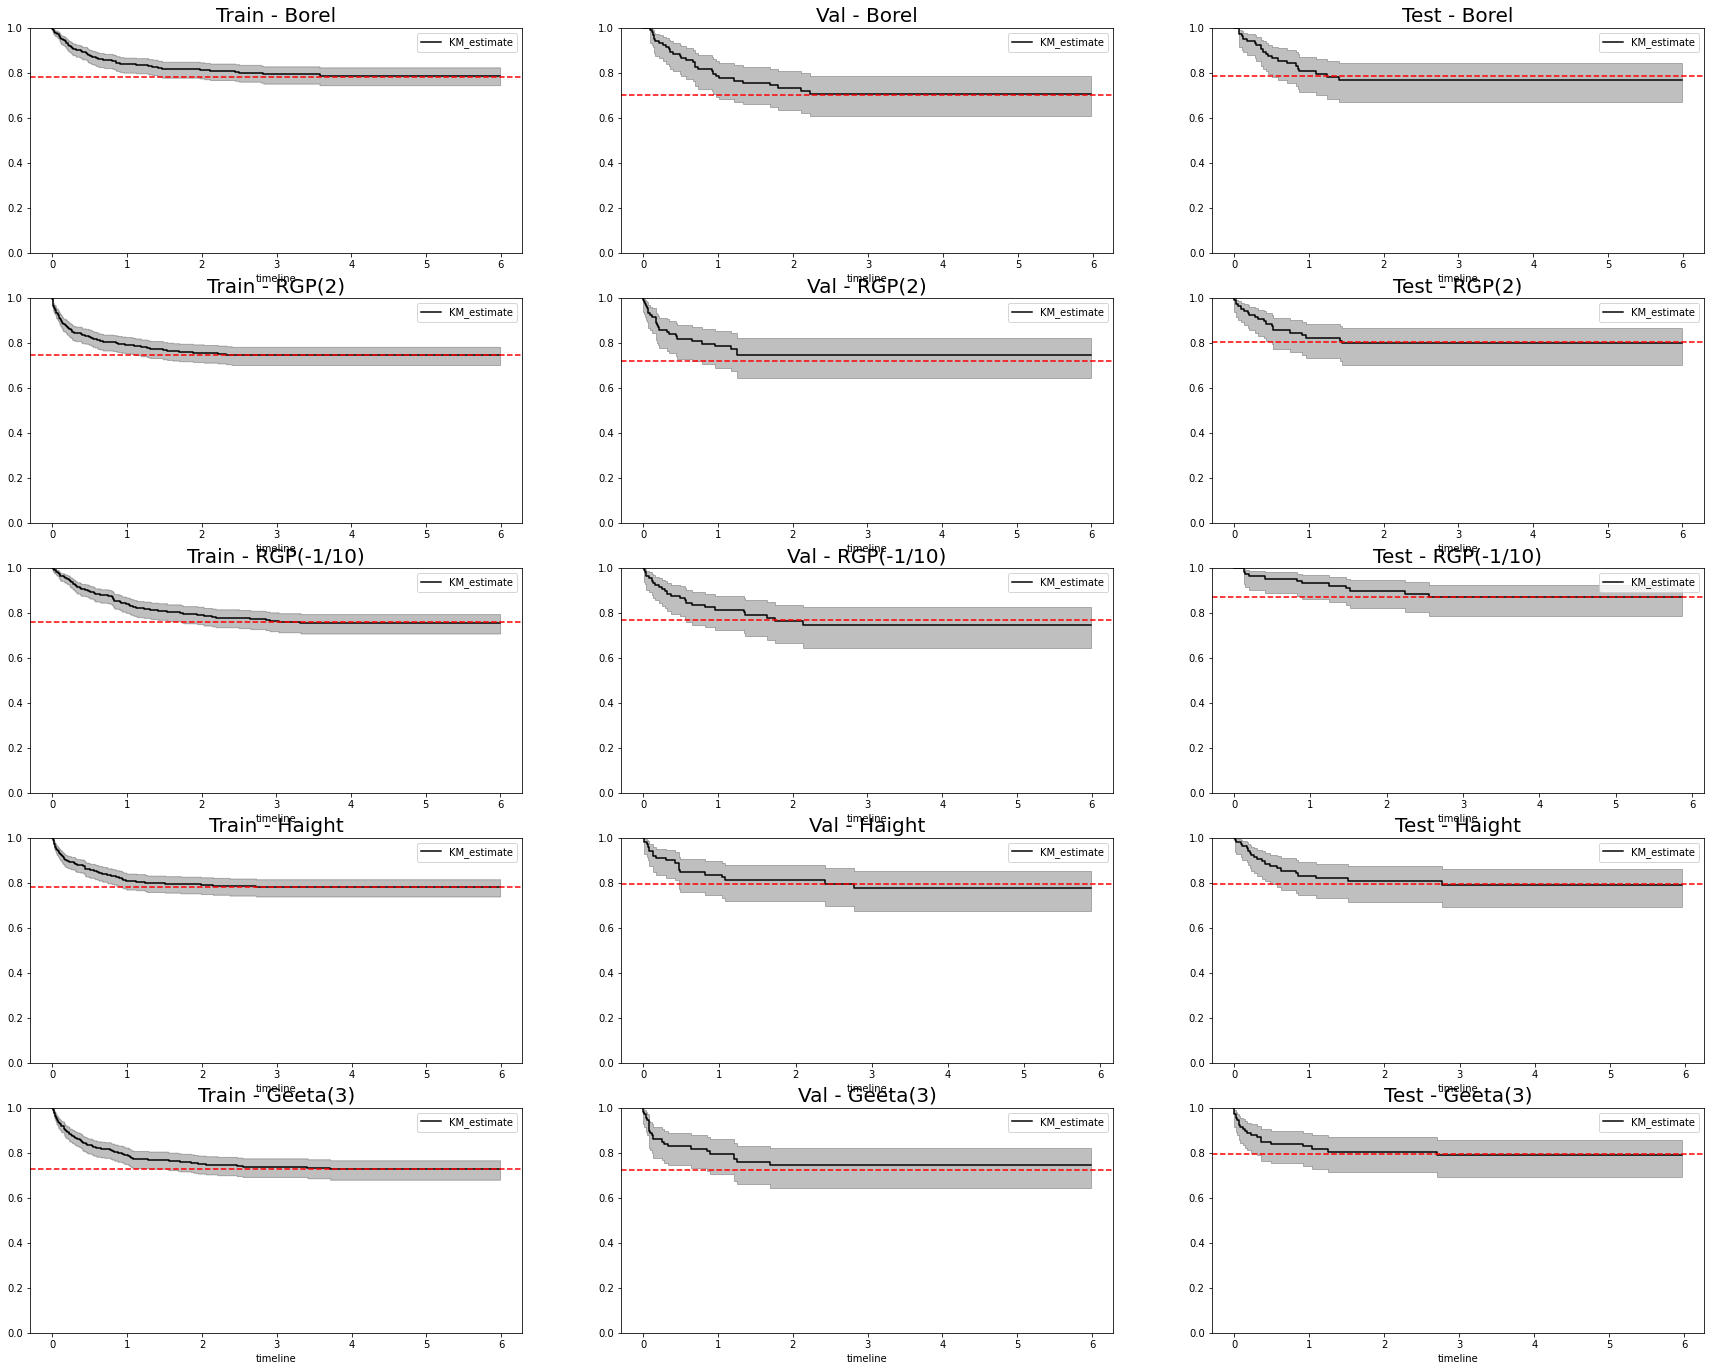

In [26]:
fig, ax = plt.subplots(nrows = 5, ncols = 3, figsize = (30,24))

# ---------------------------- Borel ----------------------------
plot_lifelines(t_train_borel2, delta_train_borel2, cured_train_borel2, ax[0,0], "Train - Borel")
plot_lifelines(t_val_borel2, delta_val_borel2, cured_val_borel2, ax[0,1], "Val - Borel")
plot_lifelines(t_test_borel2, delta_test_borel2, cured_test_borel2, ax[0,2], "Test - Borel")

# ---------------------------- RGP(q = 2) ----------------------------
plot_lifelines(t_train_2rgp2, delta_train_2rgp2, cured_train_2rgp2, ax[1,0], "Train - RGP(2)")
plot_lifelines(t_val_2rgp2, delta_val_2rgp2, cured_val_2rgp2, ax[1,1], "Val - RGP(2)")
plot_lifelines(t_test_2rgp2, delta_test_2rgp2, cured_test_2rgp2, ax[1,2], "Test - RGP(2)")

# ---------------------------- RGP(q = -1/10) ----------------------------
plot_lifelines(t_train_01rgp2, delta_train_01rgp2, cured_train_01rgp2, ax[2,0], "Train - RGP(-1/10)")
plot_lifelines(t_val_01rgp2, delta_val_01rgp2, cured_val_01rgp2, ax[2,1], "Val - RGP(-1/10)")
plot_lifelines(t_test_01rgp2, delta_test_01rgp2, cured_test_01rgp2, ax[2,2], "Test - RGP(-1/10)")

# ---------------------------- Haight ----------------------------
plot_lifelines(t_train_haight2, delta_train_haight2, cured_train_haight2, ax[3,0], "Train - Haight")
plot_lifelines(t_val_haight2, delta_val_haight2, cured_val_haight2, ax[3,1], "Val - Haight")
plot_lifelines(t_test_haight2, delta_test_haight2, cured_test_haight2, ax[3,2], "Test - Haight")

# ---------------------------- Geeta ----------------------------
plot_lifelines(t_train_3geeta2, delta_train_3geeta2, cured_train_3geeta2, ax[4,0], "Train - Geeta(3)")
plot_lifelines(t_val_3geeta2, delta_val_3geeta2, cured_val_3geeta2, ax[4,1], "Val - Geeta(3)")
plot_lifelines(t_test_3geeta2, delta_test_3geeta2, cured_test_3geeta2, ax[4,2], "Test - Geeta(3)")

Baseado no código dado nesta seção, façamos um arquivo .py com todas as funções necessárias para a geração de dados como estes em grande quantidade. De fato, consideraremos um total de 100 amostras bootstrap do conjunto de dados original Fashion-MNIST para cada escolha de tamanho amostral.